In [4]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from torch.utils.data import DataLoader
from crypto_bot.utils import save_obj, load_obj
from crypto_bot.model.data import get_class_weights, get_scaled_class_weights, get_weighted_random_sampler
from crypto_bot.model.train_loop import Trainer

DATA_FOLDER = 'C:/Users/diego/crypto_bot'
WEIGHTS_PATH = 'C:/Users/diego/crypto_bot/data/models'

# Load data

In [50]:
train_ds_name = '{}/data_loaders/train_binary_dataset.ds'.format(DATA_FOLDER)
valid_ds_name = '{}/data_loaders/valid_binary_dataset.ds'.format(DATA_FOLDER)

# Load
train_dataset = load_obj(train_ds_name)
valid_dataset = load_obj(valid_ds_name)

### Sampler

In [53]:
# Binary
# weights = get_class_weights(train_dataset, 2)
weights = (1.9060870891191019e-06, 2.33737699553561e-05)

# # Multiclass
# # weights = get_class_weights(train_dataset, 3)
# weights = (2.6139690506064407e-05, 6.197937326457755e-06, 2.7187358965575367e-06)

sampler_train = get_weighted_random_sampler(train_dataset, weights)
sampler_valid = get_weighted_random_sampler(valid_dataset, weights)

### DataLoader

In [58]:
train_loader = DataLoader(train_dataset, batch_size=256, num_workers=6, sampler=sampler_train)
valid_loader = DataLoader(valid_dataset, batch_size=256, num_workers=6, sampler=sampler_valid)

# Train model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from crypto_bot.model.model import ResBlock


class ResNet(nn.Module):
    def __init__(self, n_features):
        super(ResNet, self).__init__()

        self.block1 = ResBlock(n_features, 32)
        self.do1 = nn.Dropout(0.25)
        self.block2 = ResBlock(32, 32)
        self.do2 = nn.Dropout(0.25)
        # self.block3 = ResBlock(64, 32)
        # self.do3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.do1(self.block1(x))
        x = self.do1(self.block2(x))
        # x = self.do1(self.block3(x))
        x = F.adaptive_avg_pool1d(x, 1)
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        # x = self.fc1(x)
        return x

## Train loop

In [ ]:
trainer = Trainer(ResNet(5), train_loader, valid_loader, 3)
trainer.train()

## Metrics

In [13]:
def plot_roc(data):  
    for labels, predictions, name in data:
        fpr, tpr, _ = roc_curve(labels, predictions)
        roc_auc_train_score = roc_auc_score(y_train_gt, y_train_pred)
        plt.plot(fpr, tpr, label='ROC {} (area = {:3f})'.format(name, roc_auc_train_score))

    plt.legend(loc=4)
    plt.show()
    return

In [14]:
predictions_train = []

with torch.no_grad():
    dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)
    net.to(device)

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        output = net(data.float())
        predictions_train.append([target, output])

preds_train = []
for pred in predictions_train:
    preds_train.append(
        pd.concat([
            pd.DataFrame(pred[0].cpu().numpy(), columns=['c1', 'c2', 'c3']),
            pd.DataFrame(torch.softmax(pred[1], 1).cpu().numpy(), columns=['p_c1', 'p_c2', 'p_c3'])
        ], axis=1)
    )
preds_train = pd.concat(preds_train)

In [15]:
predictions_valid = []

with torch.no_grad():
    dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)
    net.to(device)

    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        output = net(data.float())
        predictions_valid.append([target, output])

preds_valid = []
for pred in predictions_valid:
    preds_valid.append(
        pd.concat([
            pd.DataFrame(pred[0].cpu().numpy(), columns=['c1', 'c2', 'c3']),
            pd.DataFrame(torch.softmax(pred[1], 1).cpu().numpy(), columns=['p_c1', 'p_c2', 'p_c3'])
        ], axis=1)
    )
preds_valid = pd.concat(preds_valid)

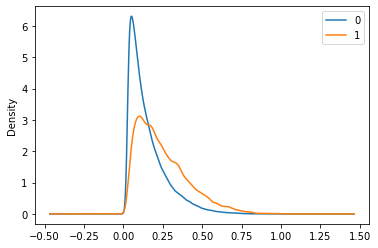

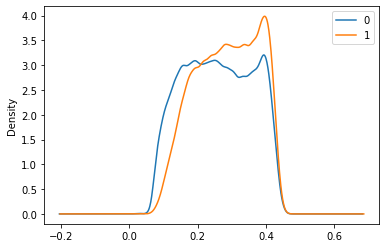

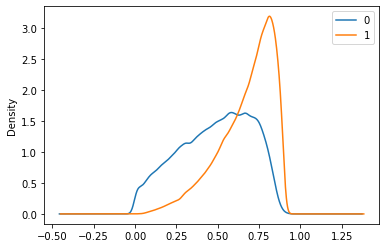

In [16]:
from matplotlib import pyplot
for i in range(1,4):
    preds_train.groupby('c{}'.format(i))['p_c{}'.format(i)].plot(kind='density', legend=True)
    pyplot.show()

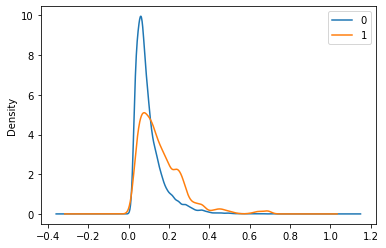

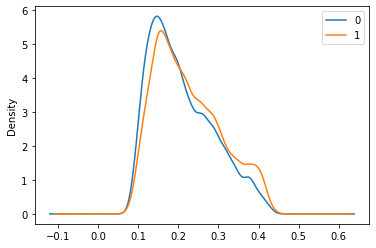

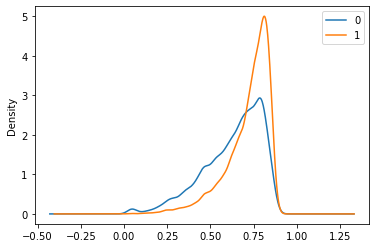

In [17]:
for i in range(1,4):
    preds_valid.groupby('c{}'.format(i))['p_c{}'.format(i)].plot(kind='density', legend=True)
    pyplot.show()

## Train loop  (binary)

In [68]:
trainer = Trainer(ResNet(5), train_loader, valid_loader, 3)
trainer.train()

Epoch: 1/3 - 45.12%
Epoch: 1/3 - 90.23%
Epoch: 1/3 - Train Loss: 0.5361081750934921 - Valid loss 0.5622323301860265
Epoch: 2/3 - 35.33%
Epoch: 2/3 - 80.44%
Epoch: 2/3 - Train Loss: 0.5228020687279639 - Valid loss 0.5686044536318098
Epoch: 3/3 - 25.54%
Epoch: 3/3 - 70.65%
Epoch: 3/3 - Train Loss: 0.5050308771186118 - Valid loss 0.5884888235160283


ResNet(
  (block1): ResBlock(
    (conv1): Conv1d(5, 32, kernel_size=(8,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (do1): Dropout(p=0.25, inplace=False)
  (block2): ResBlock(
    (conv1): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,

In [19]:
import torch.optim as optim


losses = {'train': [], 'valid': []}
def train(net, data_loader, valid_loader=None, epochs=10, lr=0.001, weights=None):
    dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)
    print('Using device: {}'.format(device))
    net.to(device)
    data_loader.dataset.to(device)
    if valid_loader:
        valid_loader.dataset.to(device)
    if weights:
        weights = weights.to(device)

    criterion = nn.BCELoss(weights)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    percentage_factor = 100 / len(data_loader.dataset)

    # net = net.float()

    iters = 0
    for epoch in range(epochs):
        total = 0
        train_loss = 0
        valid_loss = 0
        net.train()

        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            total += target.size()[0]
            
            optimizer.zero_grad()
            output = net(data.float())
            loss = criterion(output, target.float().unsqueeze(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            iters += 1
            if iters % 1000 == 0:
                print('Epoch: {}/{} - {:.2f}%'.format(epoch + 1, epochs, total * percentage_factor))

        t_loss = train_loss / len(data_loader)
        losses['train'].append(t_loss)
        print('Epoch: {}/{} - Train Loss: {}'.format(epoch + 1, epochs, t_loss))
        
        if valid_loader:
            net.eval()
            for data, target in valid_loader:
                data = data.to(device)
                target = target.to(device)
                output = net(data.float())
                loss = criterion(output, target.float().unsqueeze(-1))
                valid_loss += loss.item()
            
            v_loss = valid_loss / len(valid_loader)
            losses['valid'].append(v_loss)
            print('Epoch: {}/{} - Valid loss {}'.format(epoch + 1, epochs, v_loss))

    return net

In [ ]:
trainer = Trainer()

In [20]:
# from crypto_bot.model.model import ResNet

net = ResNet(5)
net = train(net, train_loader, valid_loader=valid_loader, epochs=3, lr=0.001)

Using device: cuda:0


C:\Users\diego\anaconda3\envs\crypto_bot\lib\site-packages\torch\nn\modules\conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 1/3 - 45.12%
Epoch: 1/3 - 90.23%
Epoch: 1/3 - Train Loss: 0.5370338766973837
Epoch: 1/3 - Valid loss 0.0
Epoch: 2/3 - 35.33%
Epoch: 2/3 - 80.44%
Epoch: 2/3 - Train Loss: 0.5220157975918224
Epoch: 2/3 - Valid loss 0.0
Epoch: 3/3 - 25.54%
Epoch: 3/3 - 70.65%
Epoch: 3/3 - Train Loss: 0.49838640658125233
Epoch: 3/3 - Valid loss 0.0


In [47]:
# from crypto_bot.model.model import save_weights

# save_weights(net, 'sell_v1', WEIGHTS_PATH)

target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

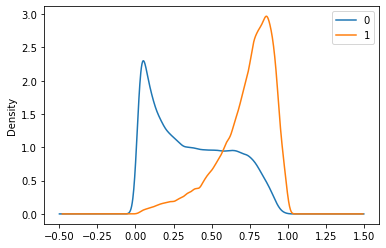

In [23]:
predictions_train = []

with torch.no_grad():
    dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)
    net.to(device)
    train_loader.dataset.to(device)

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        output = net(data.float())
        predictions_train.append([target, output])

preds_train = []
for pred in predictions_train:
    preds_train.append(
        pd.concat([
            pd.DataFrame(pred[0].cpu().numpy(), columns=['target']),
            pd.DataFrame(pred[1].cpu().numpy(), columns=['pred'])
        ], axis=1)
    )
preds_train = pd.concat(preds_train)
preds_train.groupby('target')['pred'].plot(kind='density', legend=True)

target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

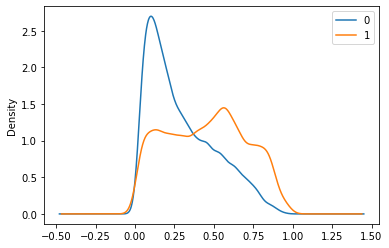

In [59]:
predictions_valid = []

with torch.no_grad():
    dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)
    net.to(device)
    valid_loader.dataset.to(device)

    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        output = net(data.float())
        predictions_valid.append([target, output])

preds_valid = []
for pred in predictions_valid:
    preds_valid.append(
        pd.concat([
            pd.DataFrame(pred[0].cpu().numpy(), columns=['target']),
            pd.DataFrame(pred[1].cpu().numpy(), columns=['pred'])
        ], axis=1)
    )
preds_valid = pd.concat(preds_valid)
preds_valid.groupby('target')['pred'].plot(kind='density', legend=True)

target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

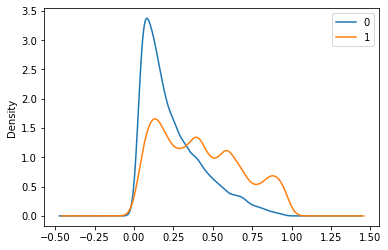

In [69]:
predictions_valid = []
net = trainer.model

with torch.no_grad():
    dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)
    net.to(device)
    valid_loader.dataset.to(device)

    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        output = net(data.float())
        predictions_valid.append([target, output])

preds_valid = []
for pred in predictions_valid:
    preds_valid.append(
        pd.concat([
            pd.DataFrame(pred[0].cpu().numpy(), columns=['target']),
            pd.DataFrame(pred[1].cpu().numpy(), columns=['pred'])
        ], axis=1)
    )
preds_valid = pd.concat(preds_valid)
preds_valid.groupby('target')['pred'].plot(kind='density', legend=True)

In [40]:
t = 0
for data, target in valid_loader:
    t += 1

In [47]:
len(valid_loader)

2217

In [46]:
preds_valid[preds_valid.pred > 0.65].target.value_counts(normalize=False)

1    1546
0    1014
Name: target, dtype: int64

In [30]:
import math

corte = 0
step = 0.025
best_score = 0
best_corte = 0

while corte < 1:
    corte += step
    try:
        score = preds_valid[preds_valid.pred > corte].target.value_counts(normalize=True)[1]
        if score > 0.65:
            best_score = score
            best_corte = corte
            break
    except Exception:
        continue

# Load models

In [48]:
from crypto_bot.model.model import load_weights, ResNetIC
buy_net = ResNetIC(5)
load_weights(buy_net, 'buy_v1', WEIGHTS_PATH)

sell_net = net

In [ ]:
WAITING = 'waiting'
HOLDING = 'holding'

class BaseTrader():
    self.CLOSE_COL = 'Close'

    def should_buy(self, data):
        pass
    
    def should_sell(self, data, bought_price):
        pass
    
    def buy(self):
        pass
    
    def sell(self):
        pass

class BaseLossLimitedTrader(BaseTrader):
    def __init__(self, loss_limit=0.3):
        self.loss_limit=loss_limit
    
    def should_sell(self, data, base_price):
        last_price = data.iloc[-1][self.CLOSE_COL]
        perc = last_price * 100 / base_price
        
        if perc < (100 - loss_limit):
            return True
        return False


class DualModelTrader():
    def __init__(self, buy_model, sell_model):
        self.buy_model = buy_model
        self.sell_model = sell_model
    
    def should_buy(self, data):
        buy_score = self.buy_model(data)
        sell_score = self.sell_model(data)
        return buy_score > 0.7 and sell_score < 0.4
    
    def should_sell(self, data, bought_price):
        should_sell = super().should_sell(data, bought_price)
        if should_sell:
            return True
        
        buy_score = self.buy_model(data)
        sell_score = self.sell_model(data)
        return buy_score < 0.4 and sell_score < 0.65